In [1]:
import os
import os.path
from collections import defaultdict
import math

from tqdm import trange

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import torch
import torchmetrics
import numpy as np
from einops import reduce, rearrange, repeat

from irwg.models import VAE
from irwg.data import MissingDataModule
from irwg.data.missing_data_module import DATASET, MISSINGNESS

from irwg.utils.stats import load_stats, load_imputations
from irwg.utils.plotting import moving_average

In [2]:
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath} \usepackage{amsfonts}"

plt.style.use('seaborn-colorblind')

In [3]:
def plot_custom_stripplot(ax, data, labels, showmedians=False, showquartiles=False, show_whiskers=False, colors=None, 
                           *, no_trim=False, only_trim_up=False, use_log_scale=False, stripplot_kw={}):
    # See https://matplotlib.org/stable/gallery/statistics/customized_violin.html#sphx-glr-gallery-statistics-customized-violin-py
    def adjacent_values(vals, q1, q3):
        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
        return lower_adjacent_value, upper_adjacent_value
    
    data = [np.array(sorted(x)) for x in data]

    assert not (no_trim and only_trim_up)
    if no_trim:
        whiskers_min = [np.nanmin(x) for x in data]
        whiskers_max = [np.nanmax(x) for x in data]
        medians = [np.nanmedian(x) for x in data]
        quartile1=None
        quartile3=None
        
        data = [x[~np.isnan(x)] for x in data]
    elif only_trim_up:
        quartile1, medians, quartile3 = np.nanpercentile(data, [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]
        whiskers_min = [np.nanmin(x) for x in data]

        # Filtering equivalent to boxplot, see https://matplotlib.org/stable/gallery/statistics/boxplot_vs_violin.html
        data = [x[np.logical_and(x >= whiskers_min[i], x <= whiskers_max[i])] for i, x in enumerate(data)]
    else:
        quartile1, medians, quartile3 = np.nanpercentile(data, [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
        whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

        # Filtering equivalent to boxplot, see https://matplotlib.org/stable/gallery/statistics/boxplot_vs_violin.html
        data = [x[np.logical_and(x >= whiskers_min[i], x <= whiskers_max[i])] for i, x in enumerate(data)]
    
    if use_log_scale:
        data = [np.log10(x) for x in data]
        whiskers_min = np.log10(whiskers_min)
        whiskers_max = np.log10(whiskers_max)
        medians = np.log10(medians)
        if quartile1 is not None:
            quartile1 = np.log10(quartile1)
        if quartile3 is not None:
            quartile3 = np.log10(quartile3)
    
#     for i, x in enumerate(data):
#         sns.stripplot(
#             ax=ax,
#             data=x,
# #             x=i,
#             c=colors[i],
#         )
    sns.stripplot(
        ax=ax,
        data=data,
        palette=colors,
        jitter=0.4,
        **stripplot_kw,
    )
    
    if use_log_scale:
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = ax.get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        ax.yaxis.set_ticks(tick_range)
        ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    inds = np.arange(0, len(medians))
    if showmedians:
        ax.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
    if showquartiles:
        ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
    if show_whiskers:
        ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

In [4]:
def load_last_nstep_imputations_from_experiment(path, last_n_steps, load_every_nth_step, 
                                                filename_prefix='imputations_'):
    versions = os.listdir(path)
    if len(versions) > 1:
        versions = list(sorted([int(v.split('version_')[1]) for v in versions]))
        v = versions[-1]
        v = f'version_{v}'
        print(f'Multiple versions found in {path}, loading {v}.')
    else:
        v = versions[0]
        
    path = os.path.join(path, v)
    
    imp_files = [f for f in os.listdir(path) if f.startswith(filename_prefix) and f.endswith('.npz')]
    batch_idxs = [int(f.split(filename_prefix)[1].split('.npz')[0]) for f in imp_files]
    imp_files = [f for _, f in sorted(zip(batch_idxs, imp_files))]
    data = defaultdict(list)
    if last_n_steps == -1:
        last_n_steps = 0
    for f in imp_files:
        f = np.load(os.path.join(path, f))
        keys = list(f.keys())
        for k in keys:
            if k == 'imputations':

                data[k].append(f[k][-last_n_steps::load_every_nth_step])
            else:
                data[k].append(f[k])

    for k in list(data.keys()):
        if k == 'imputations':
            data[k] = np.concatenate(data[k], axis=1)
            data[k] = rearrange(data[k], 't b k ... -> b k t ...')
        else:
            data[k] = np.concatenate(data[k], axis=0)

    return data

def load_last_nstep_imputations_from_experiment_multiseed(path, seeds, last_n_steps, load_every_nth_step, 
                                                         filename_prefix='imputations_'):
    final_imps = {}
    for i, seed in enumerate(seeds):
        stats = load_last_nstep_imputations_from_experiment(path.format(seed), last_n_steps, load_every_nth_step, 
                                                            filename_prefix=filename_prefix)
        if i == 0:
            final_imps = stats
        else:
            assert np.allclose(final_imps['masks'], final_imps['masks'])
            assert np.allclose(final_imps['true_X'], final_imps['true_X'])
            final_imps['imputations'] = np.concatenate([final_imps['imputations'], stats['imputations']], axis=1)
            
    return final_imps

In [5]:
def compute_pointwise_metrics_multiseed(path_template, models, seeds, *, 
                                      data_idx_true_dataset, masks_true_dataset, X_test_true_dataset, 
                                        img_shape, data_range,
                                      use_irwg_resampled=False, load_last_n_iterations=-1):
    # To tensor
    X_test_true_dataset = torch.tensor(X_test_true_dataset)
    data_idx_true_dataset = torch.tensor(data_idx_true_dataset)
        
    rmse = {}
    mae = {}
    f1 = {}
    f1_inv = {}
    ssim = {}

    for model, dir_name in models.items():
#         X_imps_all = []
        rmse_all = []
        mae_all = []
        f1_all = []
        f1_inv_all = []
        ssim_all = []
        for seed in seeds:
            path = path_template.format(dir_name, seed)
            if not use_irwg_resampled:
                imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='imputations_')
                X_imps = torch.tensor(imps_data['imputations'])
                masks = torch.tensor(imps_data['masks'])
                data_idx = torch.tensor(imps_data['data_idx'])
            else:
                imps_data = load_last_nstep_imputations_from_experiment(path, load_last_n_iterations, 1, filename_prefix='irwg_imputations_after_final_resampling_')
                X_imps = torch.tensor(imps_data['imputations'])
                masks = torch.tensor(imps_data['masks'])
                data_idx = torch.tensor(imps_data['data_idx'])
                
            if X_imps.dtype == torch.bool:
                X_imps = X_imps.float()
                
            # Verify correct data
            assert torch.all(data_idx == data_idx_true_dataset)
            assert torch.all(masks == masks_true_dataset[:, None])
            assert torch.allclose(X_imps[:, 0]*masks, X_test_true_dataset[:, None]*masks)
            
            # MAE and RMSE
            
#             X_imps_all.append(X_imps)
        
#             X_imps = torch.concat(X_imps_all, dim=1)
            X_imps = rearrange(X_imps, 'b k t d -> b (t k) d')
            M = masks
            M_not = ~M

            # Make observed values NaN
            X_imps[repeat(masks, 'b 1 d -> b k d', k=X_imps.shape[1])] = float('nan')

            diff = torch.nansum(X_imps - X_test_true_dataset[:, None], dim=-1)

            rmse_all.append(torch.mean((torch.mean(diff**2, dim=-1)**0.5), dim=0))
            mae_all.append(torch.mean(torch.absolute(diff)))
        
            # F1 scores
        
            X_imps = X_imps.bool()
            X_test_true_dataset_bool = X_test_true_dataset.bool()
        
            true_pos = reduce((X_test_true_dataset_bool[:, None] & X_imps)*M_not, 'b ... -> ', 'sum')
            false_pos = reduce((~X_test_true_dataset_bool[:, None] & X_imps)*M_not, 'b ... -> ', 'sum')
            false_neg = reduce((X_test_true_dataset_bool[:, None] & ~X_imps)*M_not, 'b ... -> ', 'sum')

            f1_score = true_pos / (true_pos + 0.5*(false_pos + false_neg))
            f1_all.append(f1_score)
            
            X_imps_neg = ~(X_imps.bool())
            X_test_true_dataset_bool_neg = ~(X_test_true_dataset.bool())
            
            true_pos = reduce((X_test_true_dataset_bool_neg[:, None] & X_imps_neg)*M_not, 'b ... -> ', 'sum')
            false_pos = reduce((~X_test_true_dataset_bool_neg[:, None] & X_imps_neg)*M_not, 'b ... -> ', 'sum')
            false_neg = reduce((X_test_true_dataset_bool_neg[:, None] & ~X_imps_neg)*M_not, 'b ... -> ', 'sum')

            f1_inv_score = true_pos / (true_pos + 0.5*(false_pos + false_neg))
            f1_inv_all.append(f1_inv_score)
            
            # SSIM

            B, K = X_imps.shape[:2]
            X_imps_ssim = rearrange(X_imps.float(), 'b k ... -> (b k) ...')
            X_test_true_dataset_ssim = repeat(X_test_true_dataset, 'b ... -> (b k) ...', k=K)

            X_imps_ssim = X_imps_ssim.reshape(len(X_imps_ssim), *img_shape)
            X_test_true_dataset_ssim = X_test_true_dataset_ssim.reshape(len(X_test_true_dataset_ssim), *img_shape)

            ssim_score = torchmetrics.functional.structural_similarity_index_measure(X_imps_ssim, X_test_true_dataset_ssim,
                                                                               gaussian_kernel=True,
                                                                               reduction='none',
                                                                               data_range=data_range)
            
            ssim_score = rearrange(ssim_score, '(b k) -> b k', b=B, k=K)
            ssim_score = ssim_score.mean()#(-1)
            
            ssim_all.append(ssim_score)
        
        rmse[model] = torch.tensor(rmse_all)
        mae[model] = torch.tensor(mae_all)
        f1[model] = torch.tensor(f1_all)
        f1_inv[model] = torch.tensor(f1_inv_all)
        ssim[model] = torch.tensor(ssim_all)
        
    return {
        'rmse': rmse,
        'mae': mae,
        'f1': f1,
        'f1_inv': f1_inv,
        'ssim': ssim,
    }

## Pointwise metrics

In [11]:
ds = 'omniglot28x28_bin'
ds_datamodule = 'omniglot28x28_fbin'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_convresnet2_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_convresnet2_k5_pseudo_gibbs',
    'MWG': 'vae_convresnet2_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_convresnet2_k5_mwg_with_irwg_warmup_replenish1',
#     'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_convresnet2_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_convresnet2_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_convresnet2_k4_irwg_i1_dmis_gr_mult_replenish1_finalresample',
}

img_shape = (1, 28,28)

q_to_miss_fraction = {
    'q25': 0.25, 
    'q50': 0.5,
    'q75': 0.75
}

qs = ['q25', 'q50', 'q75']
rmse_allq = {}
mae_allq = {}
f1_allq = {}
f1_inv_allq = {}
ssim_allq = {}
for q in qs:
    path_template = f'../logs/{ds}/imputation/{q}/{{}}/seed_m{{}}_d20220118/lightning_logs'

    datamodule = MissingDataModule(dataset=DATASET[ds_datamodule],
                                  missingness=MISSINGNESS['quadrants'],
                                  img_dims=(28, 28),
                                  setup_seed=20220118,
    #                               num_first_datapoints_test=3000,
                                  batch_size=200,
                                  total_miss_train=0.,
                                  total_miss_val=0.,
                                  total_miss_test=q_to_miss_fraction[q],
                                  filter_fully_missing_test=True,
                                  data_root='../data/')
    datamodule.setup('fit')
    datamodule.setup('test')

    X_test_true_dataset, masks_true_dataset, _, data_idx_true_dataset = datamodule.test_data[:][:4]
    masks_true_dataset = torch.tensor(masks_true_dataset)

    recompute = False
    if recompute:

        rmse = {}
        mae = {}
        f1 = {}
        f1_inv = {}
        ssim = {}

        out = compute_pointwise_metrics_multiseed(path_template, models, seeds, 
                                          load_last_n_iterations=1,
                                          data_idx_true_dataset=data_idx_true_dataset, 
                                          masks_true_dataset=masks_true_dataset, 
                                          X_test_true_dataset=X_test_true_dataset, 
                                          use_irwg_resampled=False,
                                                 img_shape=img_shape, data_range=1.)
        rmse = {**rmse, **out['rmse']}
        mae = {**mae, **out['mae']}
        f1 = {**f1, **out['f1']}
        f1_inv = {**f1_inv, **out['f1_inv']}
        ssim = {**ssim, **out['ssim']}

        out = compute_pointwise_metrics_multiseed(path_template, irwg_resampled_models, seeds, 
                                          load_last_n_iterations=1,
                                          data_idx_true_dataset=data_idx_true_dataset, 
                                          masks_true_dataset=masks_true_dataset, 
                                          X_test_true_dataset=X_test_true_dataset, 
                                          use_irwg_resampled=True,
                                                 img_shape=img_shape, data_range=1.)
        rmse = {**rmse, **out['rmse']}
        mae = {**mae, **out['mae']}
        f1 = {**f1, **out['f1']}
        f1_inv = {**f1_inv, **out['f1_inv']}
        ssim = {**ssim, **out['ssim']}
        
        rmse_allq[q] = rmse
        mae_allq[q] = mae
        f1_allq[q] = f1
        f1_inv_allq[q] = f1_inv
        ssim_allq[q] = ssim

        np.savez(f'./omniglot-pointwise-metrics-wholedataset/pointwise-metrics-{q}.npz', 
                 rmse=rmse, 
                 mae=mae, 
                 f1=f1,
                 f1_inv=f1_inv,
                 ssim=ssim)
    else:
        errs = np.load(f'./omniglot-pointwise-metrics-wholedataset/pointwise-metrics-{q}.npz', allow_pickle=True)
        rmse = errs['rmse'].item()
        mae = errs['mae'].item()
        f1 = errs['f1'].item()
        f1_inv = errs['f1_inv'].item()
        ssim = errs['ssim'].item()
        
        rmse_allq[q] = rmse
        mae_allq[q] = mae
        f1_allq[q] = f1
        f1_inv_allq[q] = f1_inv
        ssim_allq[q] = ssim
        

Train data size: 27396
Validation data size: 194
Test data size: 4870
Train data size: 27396
Validation data size: 194
Test data size: 4870
Train data size: 27396
Validation data size: 194
Test data size: 4870


In [12]:
q_to_title = {
    'q25': '{1}/{4}',
    'q50': '{2}/{4}',
    'q75': '{3}/{4}',
}

filter_and_map = {
    'Marginal': 'Marginal',
    'Pseudo-Gibbs': 'Pseudo-Gibbs',
    'MWG': 'MWG',
    'MWG$\'$': 'MWG$\'$',
    'AC-MWG$\'$': 'AC-MWG$\'$',
#     'AC-MWG$\'$ eps=0.3': 'AC-MWG$\'$',
    'LAIR k4': 'LAIR'
}

for q in ssim_allq.keys():
    rmse_allq[q] = {filter_and_map[m]: s for m, s in rmse_allq[q].items() if m in filter_and_map}
    mae_allq[q] = {filter_and_map[m]: s for m, s in mae_allq[q].items() if m in filter_and_map}
    f1_allq[q] = {filter_and_map[m]: s for m, s in f1_allq[q].items() if m in filter_and_map}
    f1_inv_allq[q] = {filter_and_map[m]: s for m, s in f1_inv_allq[q].items() if m in filter_and_map}
    ssim_allq[q] = {filter_and_map[m]: s for m, s in ssim_allq[q].items() if m in filter_and_map}


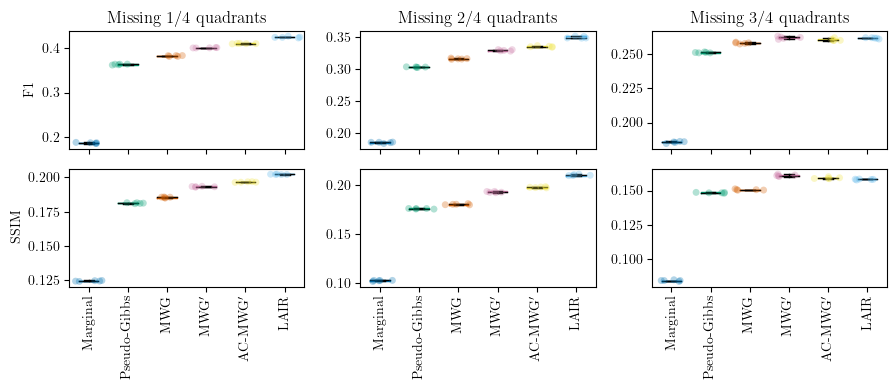

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(9, 4), sharex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for col, q in enumerate(qs):

    all_rmse = []
    all_mae = []
    all_f1 = []
    all_f1_inv = []
    all_ssim = []
    model_labels = []
    for j, model in enumerate(rmse_allq[q].keys()):
        err = rmse_allq[q][model]
        all_rmse.append(err)
        err = mae_allq[q][model]
        all_mae.append(err)
        # Note: 1-F1 and 1-SSIM to make all lower scores better
#         err = f1_allq[q][model]
#         all_f1.append(1-err)
#         err = f1_inv_allq[q][model]
#         all_f1_inv.append(1-err)
#         err = ssim_allq[q][model]
#         all_ssim.append(1-err)
        err = f1_allq[q][model]
        all_f1.append(err)
        err = f1_inv_allq[q][model]
        all_f1_inv.append(err)
        err = ssim_allq[q][model]
        all_ssim.append(err)

        model_labels.append(model)

#     # RMSE

#     bplot = axes[0, col].boxplot(all_rmse, 
#                          positions=np.arange(len(all_rmse)),
#                          labels=model_labels, showfliers=False,
#                          notch=False)

#     for i, box in enumerate(bplot['boxes']):
#         box.set_color(colors[i])
#         box.set_linewidth(1)
#     for i, box in enumerate(bplot['medians']):
#         box.set_color('k')
#         box.set_linewidth(1)

#     plot_custom_stripplot(axes[0, col], all_rmse, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=False,
#                           stripplot_kw={'alpha': 0.3})

#     # MAE

#     bplot = axes[1, col].boxplot(all_mae, 
#                          positions=np.arange(len(all_mae)),
#                          labels=model_labels, showfliers=False,
#                          notch=False)

#     for i, box in enumerate(bplot['boxes']):
#         box.set_color(colors[i])
#         box.set_linewidth(1)
#     for i, box in enumerate(bplot['medians']):
#         box.set_color('k')
#         box.set_linewidth(1)

#     plot_custom_stripplot(axes[1, col], all_mae, model_labels, 
#                           colors=colors,
#                           no_trim=True, only_trim_up=False, 
#                           showmedians=False, 
#                           use_log_scale=False,
#                           stripplot_kw={'alpha': 0.3})
    
    # F1-inv

    row = 0
    bplot = axes[row, col].boxplot(all_f1_inv, 
                         positions=np.arange(len(all_f1_inv)),
                         labels=model_labels, showfliers=False,
                         notch=False)

    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

    plot_custom_stripplot(axes[row, col], all_f1_inv, model_labels, 
                          colors=colors,
                          no_trim=True, only_trim_up=False, 
                          showmedians=False, 
                          use_log_scale=False,
                          stripplot_kw={'alpha': 0.3})
    
    # SSIM
    row = 1
    bplot = axes[row, col].boxplot(all_ssim, 
                         positions=np.arange(len(all_ssim)),
                         labels=model_labels, showfliers=False,
                         notch=False)

    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

    plot_custom_stripplot(axes[row, col], all_ssim, model_labels, 
                          colors=colors,
                          no_trim=True, only_trim_up=False, 
                          showmedians=False, 
                          use_log_scale=False,
                          stripplot_kw={'alpha': 0.3})


    axes[-1, col].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
    plt.setp(axes[-1, col].get_xticklabels(), rotation=90, ha='center')

# axes[0, 0].set_ylabel('RMSE')
# axes[1, 0].set_ylabel('MAE')
axes[0, 0].set_ylabel('F1')
axes[1, 0].set_ylabel('SSIM')


for c in range(3):
    axes[0, c].set_title(f'Missing ${q_to_title[qs[c]]}$ quadrants')

fig.tight_layout()

# fig.savefig('figures/omniglot_pointwise_f1_and_ssim.pdf')

## Imputation scores 

In [75]:
all_q_fid_scores = {}

In [76]:
ds = 'omniglot28x28_bin'
seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

qs = ['q25', 'q50', 'q75']

models = {
    'Marginal': 'vae_convresnet2_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_convresnet2_k5_pseudo_gibbs',
    'MWG': 'vae_convresnet2_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_convresnet2_k5_mwg_with_irwg_warmup_replenish1',
#     'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_convresnet2_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_convresnet2_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
#     'LAIR k4 (iter)': 'vae_convresnet2_k4_irwg_i1_dmis_gr_mult_replenish1_finalresample',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_convresnet2_k4_irwg_i1_dmis_gr_mult_replenish1_finalresample',
}

for q in qs:

    path_template = f'../logs/{ds}/imputation/eval_imputed_distr_scores/{q}/{{}}/seed_m{{}}_d20220118/lightning_logs/version_0/'

    fid_scores_per_imputation = {}
    for model, model_path in models.items():
        all_scores = []
        for seed in seeds:
            path = path_template.format(model_path, seed)
            path = os.path.join(path, 'imp_dataset_divergences_fid_scores.npz')

            scores = np.load(path)
            all_scores.append(scores['fid_scores'])
        all_scores = np.concatenate(all_scores)
        fid_scores_per_imputation[model] = all_scores

    for model, model_path in irwg_resampled_models.items():
        all_scores = []
        for seed in seeds:
            path = path_template.format(model_path, seed)
            path = os.path.join(path, 'imp_dataset_divergences_fid_scores_irwg_resampled.npz')

            scores = np.load(path)
            all_scores.append(scores['fid_scores'])
        all_scores = np.concatenate(all_scores)
        fid_scores_per_imputation[model] = all_scores

    all_q_fid_scores[q] = fid_scores_per_imputation

In [77]:
dataset_name_map = {
    'q25': '{1}/{4}',
    'q50': '{2}/{4}',
    'q75': '{3}/{4}',
}

filter_and_map = {
    'Marginal': 'Marginal',
    'Pseudo-Gibbs': 'Pseudo-Gibbs',
    'MWG': 'MWG',
    'MWG$\'$': 'MWG$\'$',
    'AC-MWG+PGwarm': 'AC-MWG',
    'AC-MWG$\'$': 'AC-MWG$\'$',
    'LAIR k4 (iter)': 'LAIR (iter)',
    'LAIR k4': 'LAIR'
}

for ds in all_q_fid_scores.keys():
    all_q_fid_scores[ds] = {filter_and_map[m]: s for m, s in all_q_fid_scores[ds].items() if m in filter_and_map}


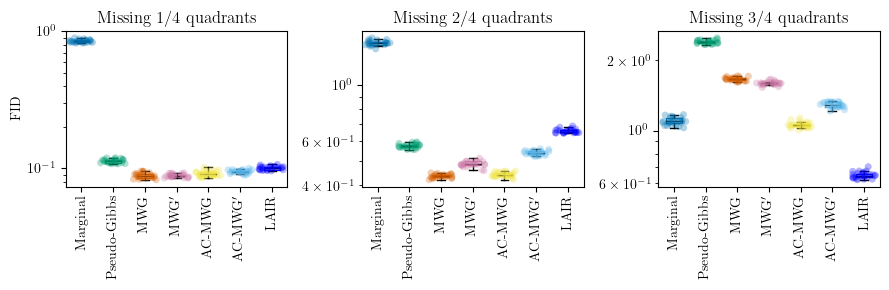

In [105]:
plot_log=False

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=False)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors += ['b', 'r', 'g', 'c', 'm']

for d, ds in enumerate(all_q_fid_scores.keys()):
    all_fid_scores_per_imputation = []
    model_labels = []
    for j, model in enumerate(all_q_fid_scores[ds].keys()):
        score = all_q_fid_scores[ds][model]
        all_fid_scores_per_imputation.append(score)

        model_labels.append(model)

    bplot_data = all_fid_scores_per_imputation
    if plot_log:
        bplot_data = [np.log10(x) for x in bplot_data]

    bplot = axes[d].boxplot(bplot_data, 
                         positions=np.arange(len(all_fid_scores_per_imputation)),
                         labels=model_labels, showfliers=False,
                         notch=False)


    for i, box in enumerate(bplot['boxes']):
        box.set_color(colors[i])
        box.set_linewidth(1)
    for i, box in enumerate(bplot['medians']):
        box.set_color('k')
        box.set_linewidth(1)

    plot_custom_stripplot(axes[d], all_fid_scores_per_imputation, model_labels, 
                          colors=colors,
                          no_trim=True, only_trim_up=False, 
                          showmedians=False, 
                          use_log_scale=plot_log,
                          stripplot_kw={'alpha': 0.3})
    
    if plot_log:
        axes[d].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
        ymin, ymax = axes[d].get_ylim()
        tick_range = np.arange(np.floor(ymin), ymax)
        axes[d].yaxis.set_ticks(tick_range)
        axes[d].yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
    

    axes[d].set_xticks(np.arange(0, len(all_fid_scores_per_imputation)), labels=model_labels)
    plt.setp(axes[d].get_xticklabels(), rotation=90, ha='center')
    
    axes[d].set_title(f'Missing {dataset_name_map[ds]} quadrants', fontsize=12)
    
# ## RMSE    
# for d, ds in enumerate(all_ds_rmse.keys()):

#     all_rmse = []
#     model_labels = []
#     for j, model in enumerate(all_ds_rmse[ds].keys()):
#         err = all_ds_rmse[ds][model]
#         all_rmse.append(err)

#         model_labels.append(model)

#     # RMSE

#     bplot = axes[1, d].boxplot(all_rmse, 
#                          positions=np.arange(len(all_rmse)),
#                          labels=model_labels, showfliers=False,
#                          notch=False)

#     for i, box in enumerate(bplot['boxes']):
#         box.set_color(colors[i])
#         box.set_linewidth(1)
#     for i, box in enumerate(bplot['medians']):
#         box.set_color('k')
#         box.set_linewidth(1)

# #     plot_custom_stripplot(axes[1, d], all_rmse, model_labels, 
# #                           colors=colors,
# #                           no_trim=True, only_trim_up=False, 
# #                           showmedians=False, 
# #                           use_log_scale=False,
# #                           stripplot_kw={'alpha': 0.3})


#     axes[1, d].set_xticks(np.arange(0, len(all_rmse)), labels=model_labels)
#     plt.setp(axes[1, d].get_xticklabels(), rotation=90, ha='center')

axes[0].set_ylabel('FID')
# axes[1, 0].set_ylabel('RMSE')

axes[0].set_yscale('log', base=10)
axes[1].set_yscale('log', base=10)
axes[2].set_yscale('log', base=10)

fig.tight_layout()

# fig.savefig('./figures/omniglot28x28_bin_.pdf')

## Imputations

In [79]:
dataset = 'omniglot28x28_bin'
path_template = f'../logs/{dataset}/imputation/{{}}/{{}}/seed_m{{}}_d20220118/lightning_logs'

seeds = ['20220118', '2022011811', '2022011822', '2022011833', '2022011844']

models = {
    'Marginal': 'vae_convresnet2_marginal_vae_baseline',
    'Pseudo-Gibbs': 'vae_convresnet2_k5_pseudo_gibbs',
    'MWG': 'vae_convresnet2_k5_mwg_with_ps_warmup',
    'MWG$\'$': 'vae_convresnet2_k5_mwg_with_irwg_warmup_replenish1',
#     'AC-MWG': 'vae_no_kl_sched_k5_mwgm_usehistrestricted_005prior_nowarm',
    'AC-MWG+PGwarm': 'vae_convresnet2_k5_mwgm_usehistrestricted_005prior_with_ps_warmup',
    'AC-MWG$\'$': 'vae_convresnet2_k5_mwgm_usehistrestricted_005prior_with_irwg_warmup_replenish1',
#     'LAIR k4 (iter)': 'vae_convresnet2_k4_irwg_i1_dmis_gr_mult_replenish1_finalresample',
}

irwg_resampled_models = {
    'LAIR k4': 'vae_convresnet2_k4_irwg_i1_dmis_gr_mult_replenish1_finalresample',
}

mis = 'q25'
imps_q25 = {}
for name, dir_name in models.items():
    imps_q25[name] = load_last_nstep_imputations_from_experiment_multiseed(path_template.format(mis, dir_name, '{}'), seeds, last_n_steps=1, load_every_nth_step=1)
for name, dir_name in irwg_resampled_models.items():
    imps_q25[name] = load_last_nstep_imputations_from_experiment_multiseed(path_template.format(mis, dir_name, '{}'), seeds, last_n_steps=1, load_every_nth_step=1, filename_prefix='irwg_imputations_after_final_resampling_')
    
mis = 'q50'
imps_q50 = {}
for name, dir_name in models.items():
    imps_q50[name] = load_last_nstep_imputations_from_experiment_multiseed(path_template.format(mis, dir_name, '{}'), seeds, last_n_steps=1, load_every_nth_step=1)
for name, dir_name in irwg_resampled_models.items():
    imps_q50[name] = load_last_nstep_imputations_from_experiment_multiseed(path_template.format(mis, dir_name, '{}'), seeds, last_n_steps=1, load_every_nth_step=1, filename_prefix='irwg_imputations_after_final_resampling_')
    
mis = 'q75'
imps_q75 = {}
for name, dir_name in models.items():
    imps_q75[name] = load_last_nstep_imputations_from_experiment_multiseed(path_template.format(mis, dir_name, '{}'), seeds, last_n_steps=1, load_every_nth_step=1)
for name, dir_name in irwg_resampled_models.items():
    imps_q75[name] = load_last_nstep_imputations_from_experiment_multiseed(path_template.format(mis, dir_name, '{}'), seeds, last_n_steps=1, load_every_nth_step=1, filename_prefix='irwg_imputations_after_final_resampling_')

dict_keys(['Marginal', 'Pseudo-Gibbs', 'MWG', "MWG$'$", 'AC-MWG+PGwarm', "AC-MWG$'$", 'LAIR k4'])


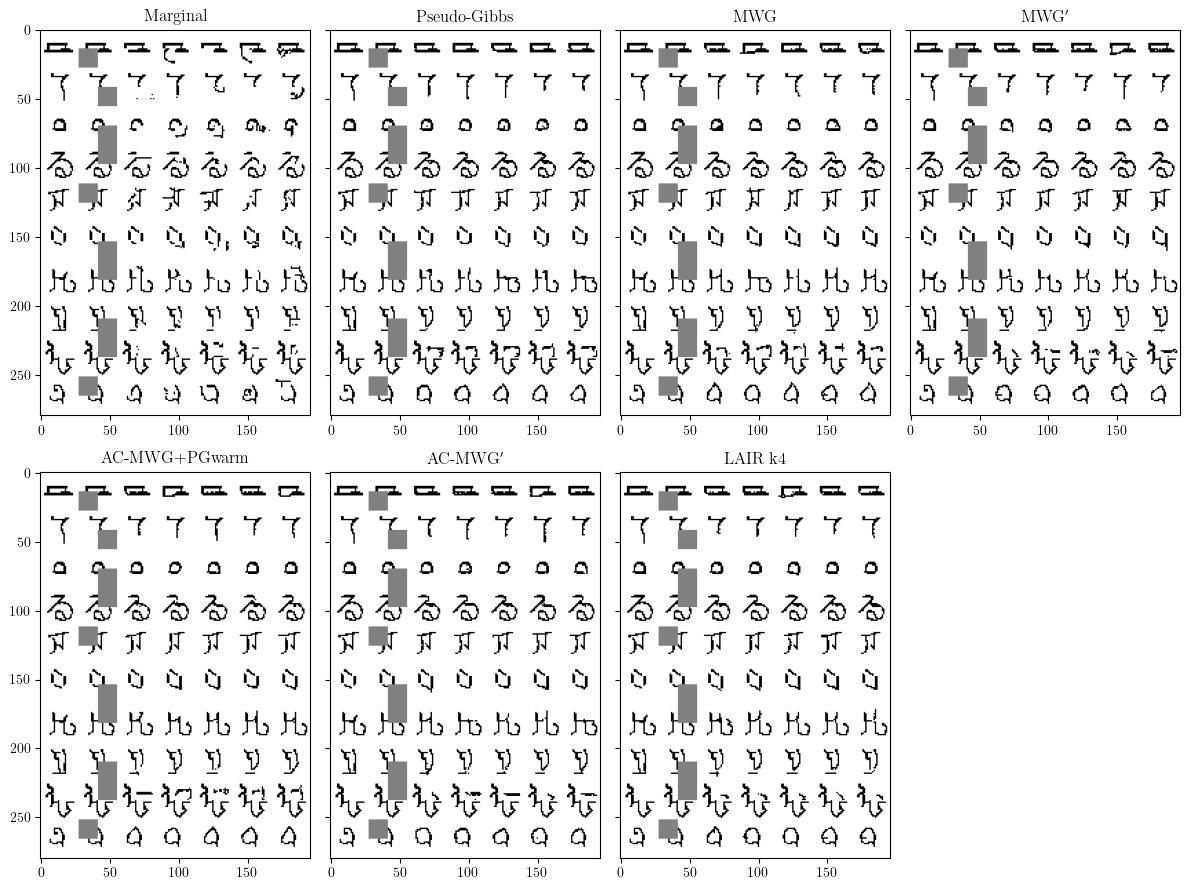

In [96]:

select_every_nth_imp = 5
N = 10
idx = np.arange(imps_q25['Pseudo-Gibbs']['imputations'].shape[0])
np.random.shuffle(idx)
idx = idx[:N]
img_dims = (28,28)

selected_imps_q25 = {}
for model, tensors in imps_q25.items():
    imps = tensors['imputations'][:, :, 0]
    imps = imps[:, ::select_every_nth_imp]
    true_X = tensors['true_X']
    if len(true_X.shape) == 2:
        true_X = repeat(true_X, 'b d -> b 1 d')
    masks = tensors['masks']
    imps = np.reshape(imps, imps.shape[:-1] + img_dims)
    selected_imps = rearrange(imps[idx], 'n t h w -> (n h) (t w)')
    true_X = true_X[idx, 0, ...]
    true_X = np.reshape(true_X, true_X.shape[:-1] + img_dims)
    true_X = rearrange(true_X, 'n h w -> (n h) w')
    masks = masks[idx, 0, ...]
    masks = np.reshape(masks, masks.shape[:-1] + img_dims)
    masks = rearrange(masks, 'n h w -> (n h) w')
    masked_X = true_X * masks + 0.5*(~masks)

    imps = np.concatenate([true_X, masked_X, selected_imps], axis=1)
    selected_imps_q25[model] = imps


num_rows = 2
fig, axes = plt.subplots(num_rows, math.ceil(len(imps_q25)/num_rows), figsize=(12, 9), sharey=True)
axes = axes.flatten()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (model, imps) in enumerate(selected_imps_q25.items()):
    axes[i].set_title(model)
    axes[i].imshow(imps, cmap='gray')
    
for i in range(len(selected_imps_q25), math.ceil(len(imps_q25)/num_rows)*num_rows):
    axes[i].axis('off')
    
print(selected_imps_q25.keys())

fig.tight_layout()

dict_keys(['Marginal', 'Pseudo-Gibbs', 'MWG', "MWG$'$", 'AC-MWG+PGwarm', "AC-MWG$'$", 'LAIR k4'])


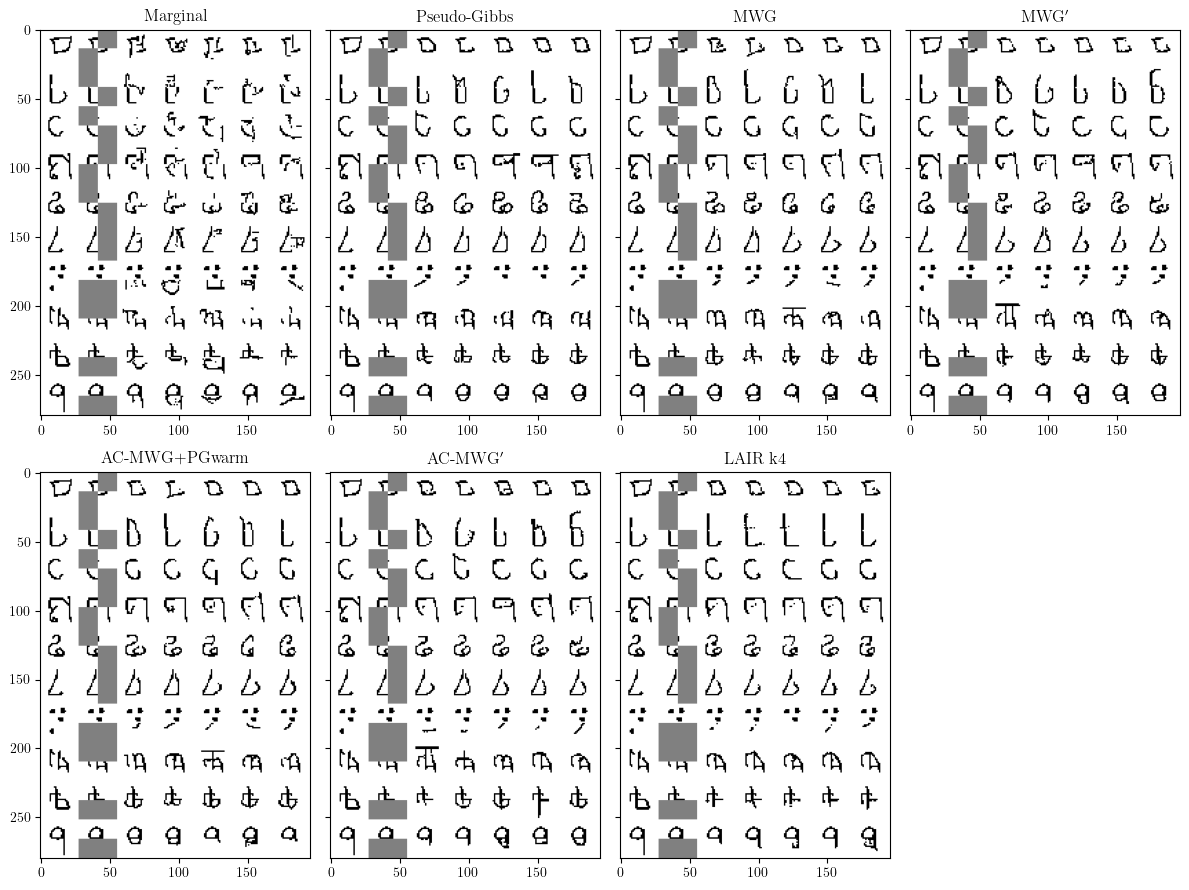

In [97]:

select_every_nth_imp = 5
N = 10
idx = np.arange(imps_q50['Pseudo-Gibbs']['imputations'].shape[0])
np.random.shuffle(idx)
idx = idx[:N]
img_dims = (28,28)

selected_imps_q50 = {}
for model, tensors in imps_q50.items():
    imps = tensors['imputations'][:, :, 0]
    imps = imps[:, ::select_every_nth_imp]
    true_X = tensors['true_X']
    if len(true_X.shape) == 2:
        true_X = repeat(true_X, 'b d -> b 1 d')
    masks = tensors['masks']
    imps = np.reshape(imps, imps.shape[:-1] + img_dims)
    selected_imps = rearrange(imps[idx], 'n t h w -> (n h) (t w)')
    true_X = true_X[idx, 0, ...]
    true_X = np.reshape(true_X, true_X.shape[:-1] + img_dims)
    true_X = rearrange(true_X, 'n h w -> (n h) w')
    masks = masks[idx, 0, ...]
    masks = np.reshape(masks, masks.shape[:-1] + img_dims)
    masks = rearrange(masks, 'n h w -> (n h) w')
    masked_X = true_X * masks + 0.5*(~masks)

    imps = np.concatenate([true_X, masked_X, selected_imps], axis=1)
    selected_imps_q50[model] = imps


num_rows = 2
fig, axes = plt.subplots(num_rows, math.ceil(len(imps_q50)/num_rows), figsize=(12, 9), sharey=True)
axes = axes.flatten()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (model, imps) in enumerate(selected_imps_q50.items()):
    axes[i].set_title(model)
    axes[i].imshow(imps, cmap='gray')
    
for i in range(len(selected_imps_q50), math.ceil(len(imps_q50)/num_rows)*num_rows):
    axes[i].axis('off')
    
print(selected_imps_q50.keys())

fig.tight_layout()

dict_keys(['Marginal', 'Pseudo-Gibbs', 'MWG', "MWG$'$", 'AC-MWG+PGwarm', "AC-MWG$'$", 'LAIR k4'])


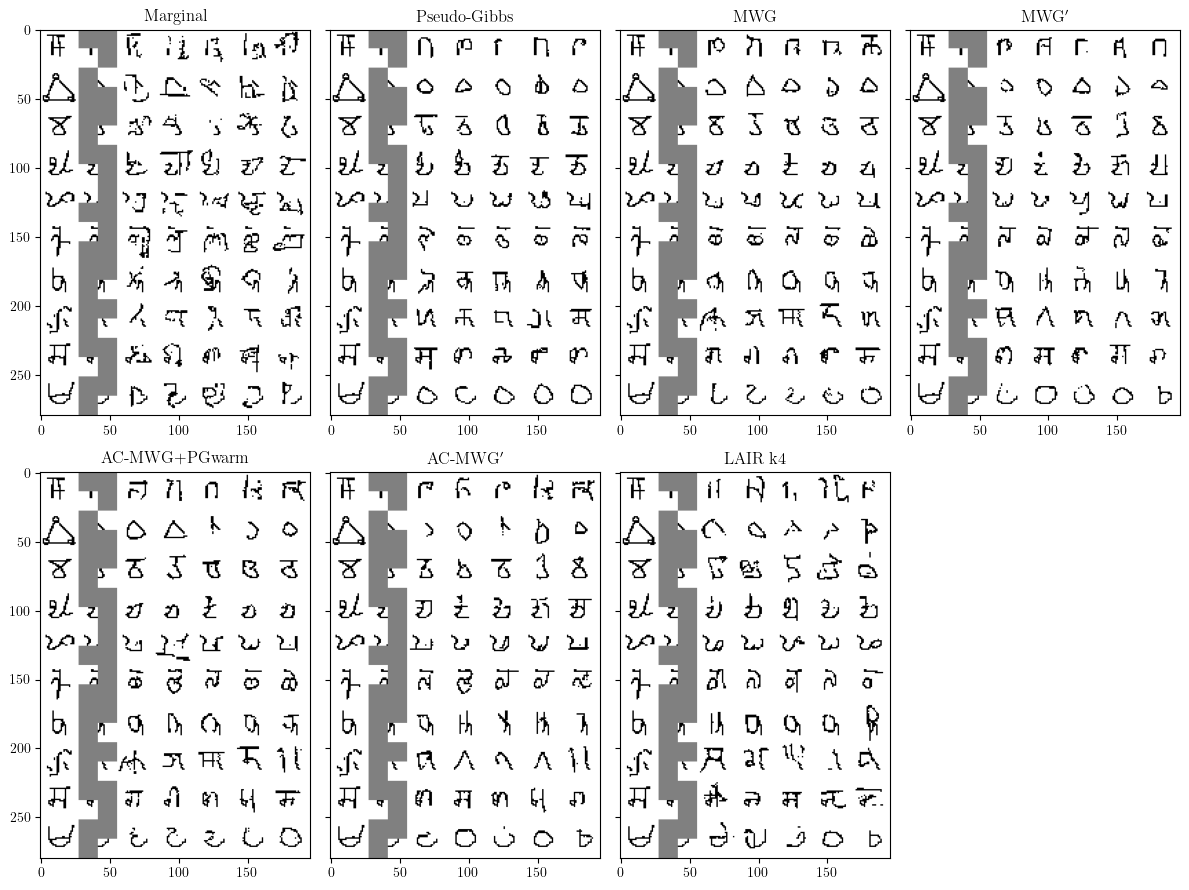

In [98]:

select_every_nth_imp = 5
N = 10
idx = np.arange(imps_q50['Pseudo-Gibbs']['imputations'].shape[0])
np.random.shuffle(idx)
idx = idx[:N]
img_dims = (28,28)

selected_imps_q75 = {}
for model, tensors in imps_q75.items():
    imps = tensors['imputations'][:, :, 0]
    imps = imps[:, ::select_every_nth_imp]
    true_X = tensors['true_X']
    if len(true_X.shape) == 2:
        true_X = repeat(true_X, 'b d -> b 1 d')
    masks = tensors['masks']
    imps = np.reshape(imps, imps.shape[:-1] + img_dims)
    selected_imps = rearrange(imps[idx], 'n t h w -> (n h) (t w)')
    true_X = true_X[idx, 0, ...]
    true_X = np.reshape(true_X, true_X.shape[:-1] + img_dims)
    true_X = rearrange(true_X, 'n h w -> (n h) w')
    masks = masks[idx, 0, ...]
    masks = np.reshape(masks, masks.shape[:-1] + img_dims)
    masks = rearrange(masks, 'n h w -> (n h) w')
    masked_X = true_X * masks + 0.5*(~masks)

    imps = np.concatenate([true_X, masked_X, selected_imps], axis=1)
    selected_imps_q75[model] = imps


num_rows = 2
fig, axes = plt.subplots(num_rows, math.ceil(len(imps_q75)/num_rows), figsize=(12, 9), sharey=True)
axes = axes.flatten()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, (model, imps) in enumerate(selected_imps_q75.items()):
    axes[i].set_title(model)
    axes[i].imshow(imps, cmap='gray')
    
for i in range(len(selected_imps_q75), math.ceil(len(imps_q75)/num_rows)*num_rows):
    axes[i].axis('off')
    
print(selected_imps_q75.keys())

fig.tight_layout()